<a href="https://colab.research.google.com/github/serhhpi/bbb/blob/main/result4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc
import io
from google.colab import files

In [200]:
# Загрузка размеченных данных для обучения

#uploaded = files.upload() #для загрузки файлов на colab
train = pd.read_csv("action_train.csv")

<ipython-input-200-e91585e9a3b4>:4: DtypeWarning: Columns (5,6,7,8,9,10,11,12,13) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("action_train.csv")


In [201]:
# Загрузка данных

#uploaded = files.upload()
test = pd.read_csv("action_test.csv")

In [202]:
# Предобработка данных

def preprocess(df):
  for i in range(1, 11):
    df[f'char_{i}'] = df[f'char_{i}'].str.findall('\d+').str.join('')
    df[f'char_{i}'] = pd.to_numeric(df[f'char_{i}'] , errors='coerce')

  #df.dropna(subset=['char_1'], inplace=True)
  return df.drop(['person_id', 'date'], axis=1)

train = preprocess(train)
test = preprocess(test)

# Определяем категориальные и числовые признаки
categorical_cols = ['action_type']
numeric_cols = [f'char_{i}' for i in range(1, 11)]

# Создаем преобразователь признаков
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numeric_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

train.dropna(subset=['char_1'], inplace=True)

In [203]:
# Подготовка данных
X = train.drop(["action_id", "result"], axis=1)
y = train["result"]
X_test = test.drop("action_id", axis=1)

In [204]:
#Обучение модели
import lightgbm as lgb
from sklearn.pipeline import make_pipeline

#Создаем модель
model = make_pipeline(
    preprocessor,
    lgb.LGBMClassifier(
        n_estimators=500,
        learning_rate=0.05,
        random_state=42,
        class_weight='balanced',
        metric='auc'
    )
)

# Обучаем модель
model.fit(X, y)



/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 64831, number of negative: 92784
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005125 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 165
[LightGBM] [Info] Number of data points in the train set: 157615, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=-0.000000
[LightGBM] [Info] Start training from score -0.000000


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['char_1', 'char_2', 'char_3',
                                                   'char_4', 'char_5', 'char_6',
                                                   'char_7', 'char_8', 'char_9',
                                                   'char_10']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['action_type'])])),
                ('lgbmclassifier',
                 LGBMClassifier(class_weight='balanced', learning_rate=0.05,
                                metric='auc', n_estimators=500,
                                random_state=42))])

In [205]:
# Предсказываем вероятности
test['result'] = model.predict_proba(X_test)[:, 1]


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [198]:
# Сохраняем результаты
results = test[['action_id', 'result']]
results.to_csv('predictions.csv', index=False)

In [206]:
# Оценка модели
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
model.fit(X_train, y_train)
val_probs = model.predict_proba(X_val)[:, 1]

roc_auc = roc_auc_score(y_val, val_probs)

print(f"AUC-ROC: {roc_auc:.3f}")

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[LightGBM] [Info] Number of positive: 45488, number of negative: 64842
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003603 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 163
[LightGBM] [Info] Number of data points in the train set: 110330, number of used features: 9
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


AUC-ROC: 0.692


AUC-ROC: 0.692


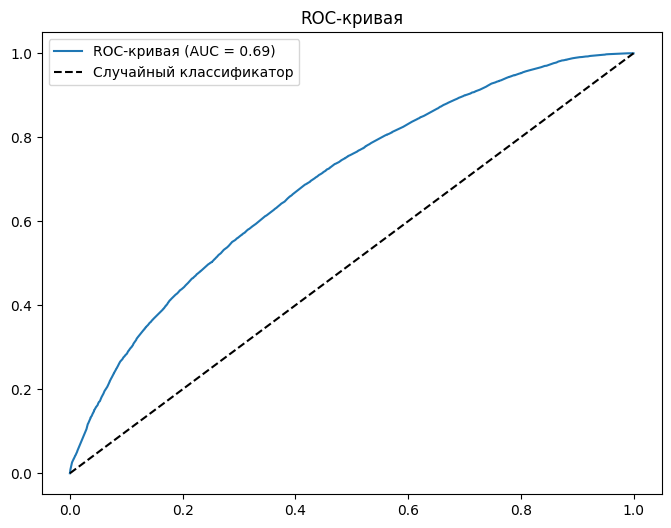

In [207]:
fpr, tpr, thresholds = roc_curve(y_val, val_probs)
roc_auc = roc_auc_score(y_val, val_probs)

print(f"AUC-ROC: {roc_auc:.3f}")

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Случайный классификатор')
plt.title('ROC-кривая')
plt.legend()
plt.show()